In [8]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from scipy.stats import pearsonr, spearmanr, ks_2samp, mannwhitneyu, ttest_ind

import sys
sys.path.append('../')

import utils
from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
dlcst_PREDS = f"{EXPERIMENT_DIR}/dlcst"

DLCST_PREDS_LOCAL = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/dlcst"
DLCST_PREDS = DLCST_PREDS_LOCAL ## Comment out if not using Teams backup (aka Chansey is up :)

## Load predictions

In [9]:
dlcst_preds = pd.read_csv(f"{DLCST_PREDS}/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [10]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

## Pick threshold policies

In [11]:
THRESHOLD = utils.ILST_THRESHOLD
THRESHOLD

0.06

### Venkadesh

,Sensitivity,Specificity,Youden J
0.0,1.000000,0.000000,0.000000
0.1,0.932203,0.855556,0.787759
0.2,0.830508,0.885185,0.715694
0.3,0.779661,0.898148,0.677809
0.4,0.762712,0.911111,0.673823
0.5,0.745763,0.927778,0.673540
0.6,0.745763,0.935185,0.680948
0.7,0.694915,0.942593,0.637508
0.8,0.542373,0.957407,0.499780
0.9,0.423729,0.977778,0.401507


Peak Youden's J statistic (TPR - FPR): 0.7896107972379158


,Sensitivity,Specificity,Youden J
0.105,0.932203,0.857407,0.789611
0.106,0.932203,0.857407,0.789611
0.107,0.932203,0.857407,0.789611
0.108,0.932203,0.857407,0.789611


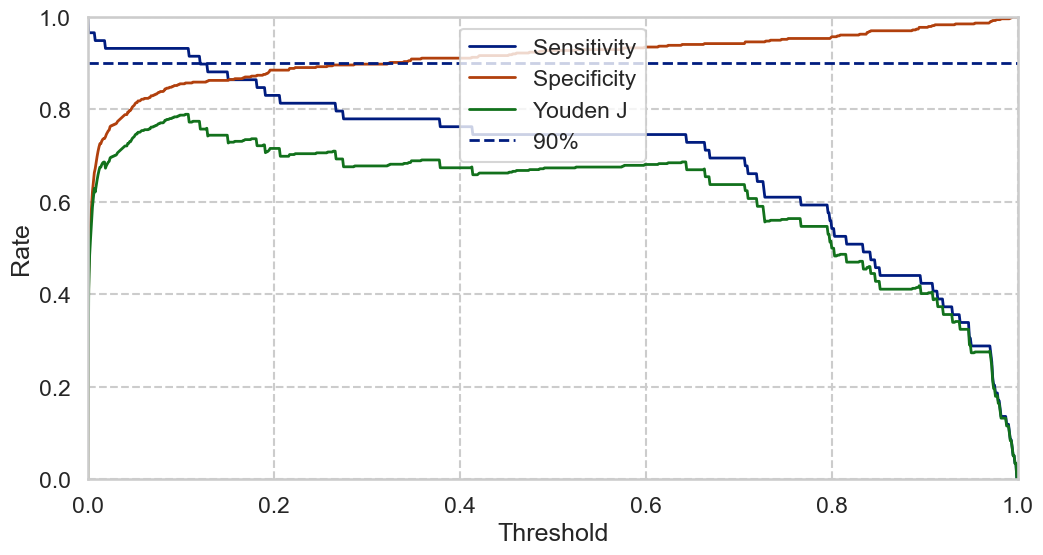

### de Haas

,Sensitivity,Specificity,Youden J
0.0,1.000000,0.000000,0.000000
0.1,0.949153,0.690741,0.639893
0.2,0.881356,0.818519,0.699874
0.3,0.813559,0.868519,0.682078
0.4,0.779661,0.911111,0.690772
0.5,0.694915,0.942593,0.637508
0.6,0.627119,0.955556,0.582674
0.7,0.423729,0.979630,0.403358
0.8,0.322034,0.990741,0.312775
0.9,0.152542,0.998148,0.150691


Peak Youden's J statistic (TPR - FPR): 0.7109855618330194


,Sensitivity,Specificity,Youden J
0.213,0.881356,0.82963,0.710986


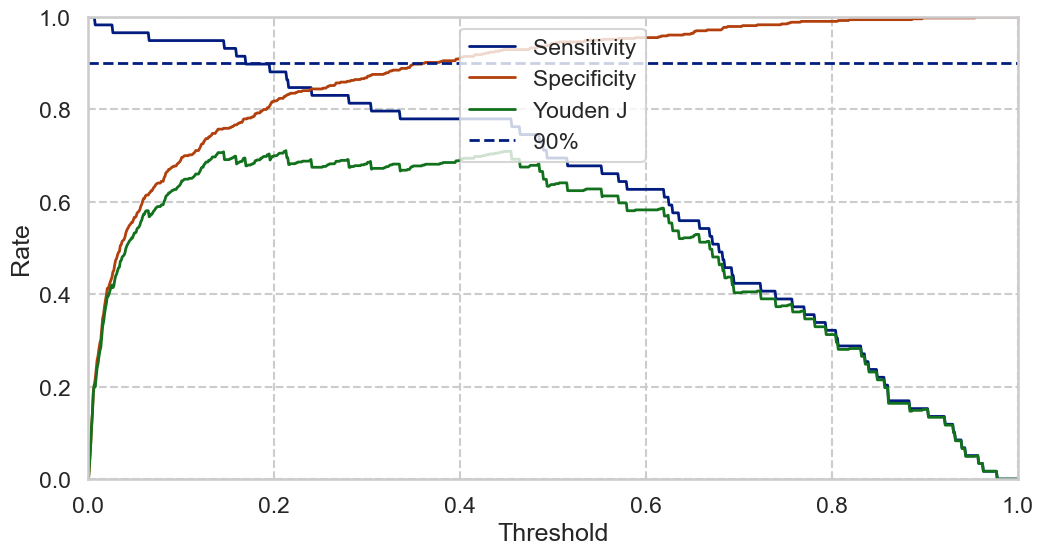

### Sybil

,Sensitivity,Specificity,Youden J
0.0,1.000000,0.088889,0.088889
0.1,0.491525,0.955556,0.447081
0.2,0.254237,0.985185,0.239422
0.3,0.169492,0.988889,0.158380
0.4,0.101695,0.998148,0.099843
0.5,0.050847,1.000000,0.050847
0.6,0.033898,1.000000,0.033898
0.7,0.016949,1.000000,0.016949
0.8,0.016949,1.000000,0.016949
0.9,0.000000,1.000000,0.000000


Peak Youden's J statistic (TPR - FPR): 0.6437539234149403


,Sensitivity,Specificity,Youden J
0.005,0.847458,0.796296,0.643754
0.006,0.847458,0.796296,0.643754


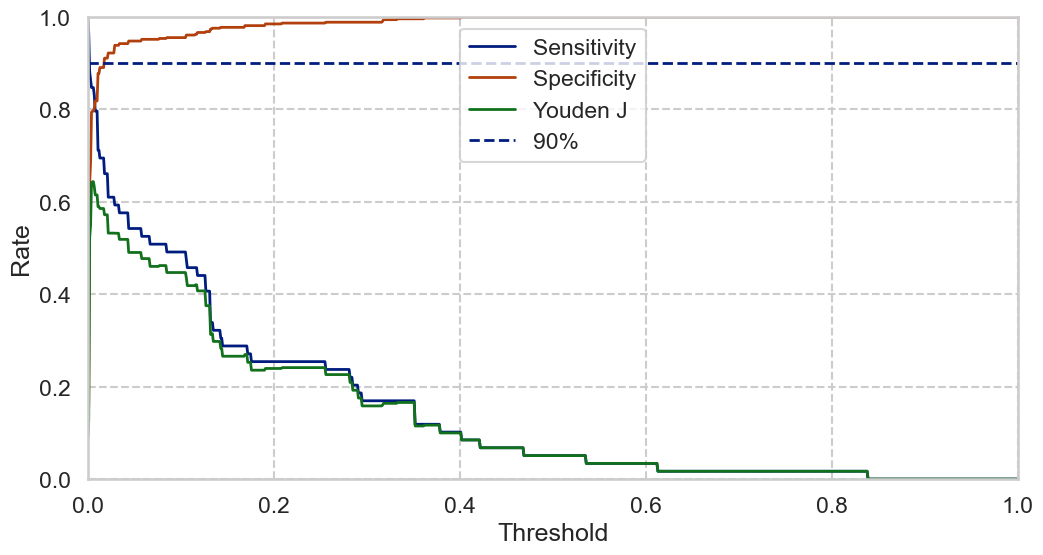

### PanCan2b

,Sensitivity,Specificity,Youden J
0.0,1.000000,0.187037,0.187037
0.1,0.627119,0.911111,0.538230
0.2,0.457627,0.950000,0.407627
0.3,0.254237,0.970370,0.224608
0.4,0.186441,0.979630,0.166070
0.5,0.135593,0.987037,0.122630
0.6,0.067797,0.996296,0.064093
0.7,0.033898,1.000000,0.033898
0.8,0.000000,1.000000,0.000000
0.9,0.000000,1.000000,0.000000


Peak Youden's J statistic (TPR - FPR): 0.6575643440050221


,Sensitivity,Specificity,Youden J
0.029,0.898305,0.759259,0.657564


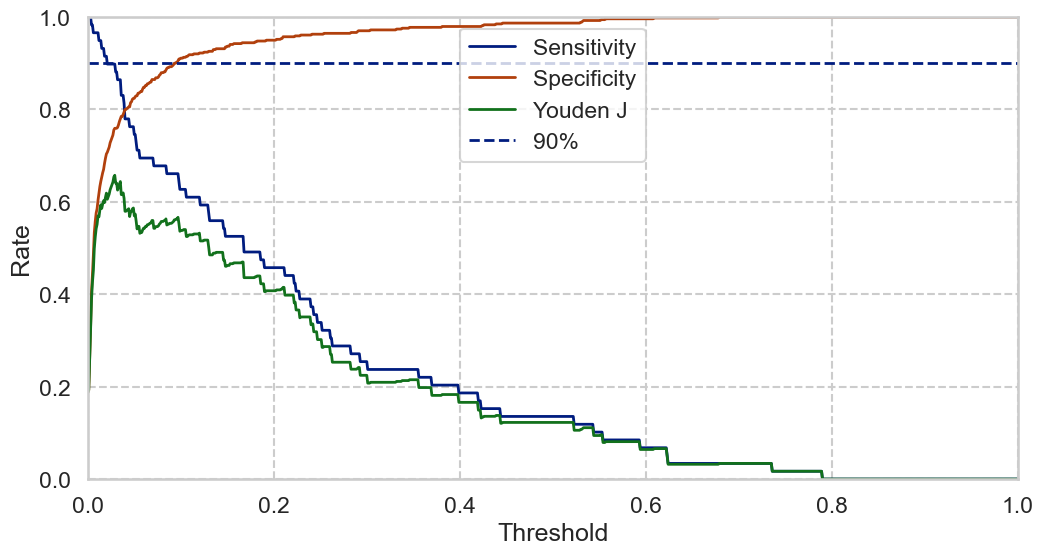

In [12]:
DATASET_NAME = 'DLCST'
N = len(dlcst_preds)

threshold_info = {}
threshold_precision = 3
threshold_cands = np.arange(0, 1, 10**(-1 * threshold_precision))

true_col = dlcst_preds['label']
for m in MODEL_TO_COL:
    pred_col = dlcst_preds[MODEL_TO_COL[m]]
    stats = {}
    for t in threshold_cands:
        stats[np.around(t, threshold_precision)] = utils.stats_from_cm(*utils.cm_with_thres(dlcst_preds, threshold=t, pred_col=MODEL_TO_COL[m], true_col='label'))
    
    statdf = pd.DataFrame(stats).T
    statdf['Sensitivity'] = statdf['tpr']
    statdf['Specificity'] = statdf['tnr']
    statdf['Youden J'] = statdf['j']

    threshold_info[m] = statdf[['Sensitivity', 'Specificity', 'Youden J']]
    display(Markdown(f"### {m}"))
    display(statdf.loc[[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],['Sensitivity', 'Specificity', 'Youden J']])

    fig = plt.figure(figsize=(12, 6))
    for c in ['Sensitivity', 'Specificity', 'Youden J']:
        plt.plot(threshold_cands, threshold_info[m][c], label=c)

    max_j = threshold_info[m]['Youden J'].max()
    print("Peak Youden's J statistic (TPR - FPR):", max_j)
    display(threshold_info[m][threshold_info[m]['Youden J'] == max_j])
    
    plt.axhline(y=0.9, linestyle='--', label='90%')
    plt.legend(loc='upper center')
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()

Find 90% sensitivity and specificity thresholds for each model.

In [16]:
policies = (
    ('Sensitivity', 0.9),
    # ('Sensitivity', 1.0),
    ('Specificity', 0.9),
    # ('Specificity', 1.0),  
    ('Youden J', 1.0) ## Max J statistic
)
policy_thresholds = {}

for col, val in policies:
    display(Markdown(f"### {col} = {val}"))
    cols_list = ['Sensitivity', 'Specificity', 'Youden J']
    cols_list.remove(col)
    policy_thresholds[f'{col}={val}'] = {}


    for m in MODEL_TO_COL:
        display(Markdown(f"#### {m}"))
        # sorted_df = threshold_info[m].iloc[(threshold_info[m][col]-val).abs().argsort()]
        df = threshold_info[m]
        df[f"abs_diff"] = abs(df[col] - val)
        df = df.sort_values(by=['abs_diff', *cols_list], ascending=[True, False, False])
        df = df.drop(columns=['abs_diff'])
        display(df.head(1))

        policy_thresholds[f'{col}={val}'][m] = list(df.index.values)[0]

policy_threshold_df = pd.DataFrame(policy_thresholds)
policy_threshold_df['Brock'] = [utils.ILST_THRESHOLD] * len(policy_threshold_df)
display(policy_threshold_df)

### Sensitivity = 0.9

#### Venkadesh

,Sensitivity,Specificity,Youden J
0.128,0.898305,0.861111,0.759416


#### de Haas

,Sensitivity,Specificity,Youden J
0.195,0.898305,0.805556,0.703861


#### Sybil

,Sensitivity,Specificity,Youden J
0.002,0.881356,0.640741,0.522097


#### PanCan2b

C:\Users\shaur\AppData\Local\Temp\ipykernel_24848\1398375848.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"abs_diff"] = abs(df[col] - val)


,Sensitivity,Specificity,Youden J
0.029,0.898305,0.759259,0.657564


### Specificity = 0.9

#### Venkadesh

,Sensitivity,Specificity,Youden J
0.323,0.779661,0.9,0.679661


#### de Haas

,Sensitivity,Specificity,Youden J
0.36,0.779661,0.9,0.679661


#### Sybil

,Sensitivity,Specificity,Youden J
0.013,0.694915,0.890741,0.585656


#### PanCan2b

C:\Users\shaur\AppData\Local\Temp\ipykernel_24848\1398375848.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"abs_diff"] = abs(df[col] - val)


,Sensitivity,Specificity,Youden J
0.093,0.661017,0.9,0.561017


### Youden J = 1.0

#### Venkadesh

,Sensitivity,Specificity,Youden J
0.105,0.932203,0.857407,0.789611


#### de Haas

,Sensitivity,Specificity,Youden J
0.213,0.881356,0.82963,0.710986


#### Sybil

,Sensitivity,Specificity,Youden J
0.005,0.847458,0.796296,0.643754


#### PanCan2b

C:\Users\shaur\AppData\Local\Temp\ipykernel_24848\1398375848.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"abs_diff"] = abs(df[col] - val)


,Sensitivity,Specificity,Youden J
0.029,0.898305,0.759259,0.657564


,Sensitivity=0.9,Specificity=0.9,Youden J=1.0,Brock
Venkadesh,0.128,0.323,0.105,0.06
de Haas,0.195,0.360,0.213,0.06
Sybil,0.002,0.013,0.005,0.06
PanCan2b,0.029,0.093,0.029,0.06


In [27]:
policy_threshold_df.to_csv(f"{DLCST_PREDS}/policy-thresholds-{len(dlcst_preds)}.csv", index=True)

In [17]:
SPLIT_QUERIES = {
    "sex": {
        "male": 'Sex == 1',
        "female": 'Sex == 2' 
    },
    "family history": {
        "no": 'FamilyHistoryLungCa == 0',
        "yes": 'FamilyHistoryLungCa == 1' 
    },
    "emphysema": {
        "no": 'Emphysema == 0',
        "yes": 'Emphysema == 1' 
    },
    "age": {
        "50-62": '50 <= Age < 62',
        "62+": '62 <= Age', 
    },
    "nodule count": {
        "1": 'NoduleCountPerScan == 1',
        ">1": 'NoduleCountPerScan > 1' 
    }
}

def get_split_dfs(df, split_by="sex", printinfo=True):
    subset_dfs = {}
    for (split, query) in SPLIT_QUERIES[split_by].items():
        subset_dfs[split] = df.query(query)
        
        if printinfo:
            mal_count = len(subset_dfs[split].query('label == 1'))
            mal_percent = 100 * (mal_count / len(subset_dfs[split]))
            print(f"{split}, n={len(subset_dfs[split])}, {mal_count} malignant ({mal_percent:.2f}%)")
    
    return subset_dfs

## Plot results by category

In [18]:
def modelstats_by_cat(df, cat, threshold_df=policy_threshold_df, threshold_policy='Brock', models=MODEL_TO_COL):
    groups = get_split_dfs(df, cat, printinfo=False).items()
    df_catinfo, skips = utils.info_by_splits(groups, min_mal=10)
    if (len(df_catinfo) - len(skips)) < 2:
        return df_catinfo, None
    
    perfs = {}
    for m in models:
        stats, vals = [], []
        vals.append('ALL')
        stats.append(
            utils.stats_from_cm(
                *utils.cm_with_thres(
                    df,
                    threshold=threshold_df.loc[m, threshold_policy],
                    pred_col=models[m],
                    true_col='label',
                )
            )
        )

        for val, df_group in groups:
            if val not in skips:
                vals.append(val)
                stats.append(
                    utils.stats_from_cm(
                        *utils.cm_with_thres(
                            df_group,
                            threshold=policy_threshold_df.loc[m, threshold_policy],
                            pred_col=models[m],
                            true_col='label',
                        )
                    )
                )

        perfs[m] = pd.DataFrame(stats, index=vals)
        perfs[m]['model'] = [m] * len(perfs[m])
    
    return df_catinfo, perfs

In [23]:
def plot_by_category(df, c, 
                     threshold_df=policy_threshold_df,
                     metrics_to_plot=['fpr', 'fnr'],
                     diff=True): ## mode can be diff for differences from all
    display(Markdown(f"### {c}"))
    df_catinfo, temp_perfs = modelstats_by_cat(df, c, threshold_df=threshold_df, threshold_policy='Brock')
    display(df_catinfo)

    if temp_perfs is None:
        print("Not enough malignant samples from multiple groups. SKIP")
        return

    fig, ax = plt.subplots(len(policy_threshold_df.columns), len(metrics_to_plot), 
                           figsize=(4 * (len(df_catinfo) + (0 if diff else 1)) * len(metrics_to_plot), 1 + len(policy_threshold_df.columns) * 5),
                           sharex=False, sharey=True)

    for j, policy in enumerate(list(policy_threshold_df.columns)):
        _, perfs = modelstats_by_cat(df, c, threshold_df=threshold_df, threshold_policy=policy)
        first_df = list(perfs.values())[0]
        
        for i, metric in enumerate(metrics_to_plot):
            category = list(first_df.index.values)
            
            if diff:
                category.remove('ALL')
                perf_metrics = {m: list(perfs[m][metric] - perfs[m].loc['ALL', metric])[1:] for m in perfs}
            else:
                perf_metrics = {m: list(perfs[m][metric]) for m in perfs}
            
            
            x = np.arange(len(category))  # the label locations
            width = 0.15  # the width of the bars
            multiplier = 0

            for attribute, measurement in perf_metrics.items():
                offset = (width) * ((multiplier))
                rects = ax[j][i].bar(x + offset, measurement, width, label=attribute)
                ax[j][i].bar_label(rects, padding=3, fmt='%.2f', fontsize='x-small')
                multiplier += 1

            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax[j][i].set_ylabel(metric)
            ax[j][i].set_title(f'{DATASET_NAME} (n={len(df)}) {metric} by {c} (thresholds: {policy})')
            ax[j][i].set_xticks(x + width, [f"{val}\n({first_df.loc[val, 'mal']} mal, {first_df.loc[val, 'ben']} ben)" for val in category])
            # ax[j][i].set_xticks(x + width, category)
            # ax[j][i].legend(loc='upper left', bbox_to_anchor=(1, 1))
                        
            if diff:
                ax[j][i].set_ylim(-0.5,0.5)
            else:
                ax[j][i].set_ylim(0, 1)
            
    handles, labels = ax[0][0].get_legend_handles_labels()
    fig.suptitle(" ")
    fig.legend(handles, labels, loc='upper center', ncol=len(handles))
    plt.tight_layout()
    plt.show()

### sex

,num,pct,num_mal,pct_mal
male,323,53.923205,32,9.907121
female,276,46.076795,27,9.782609


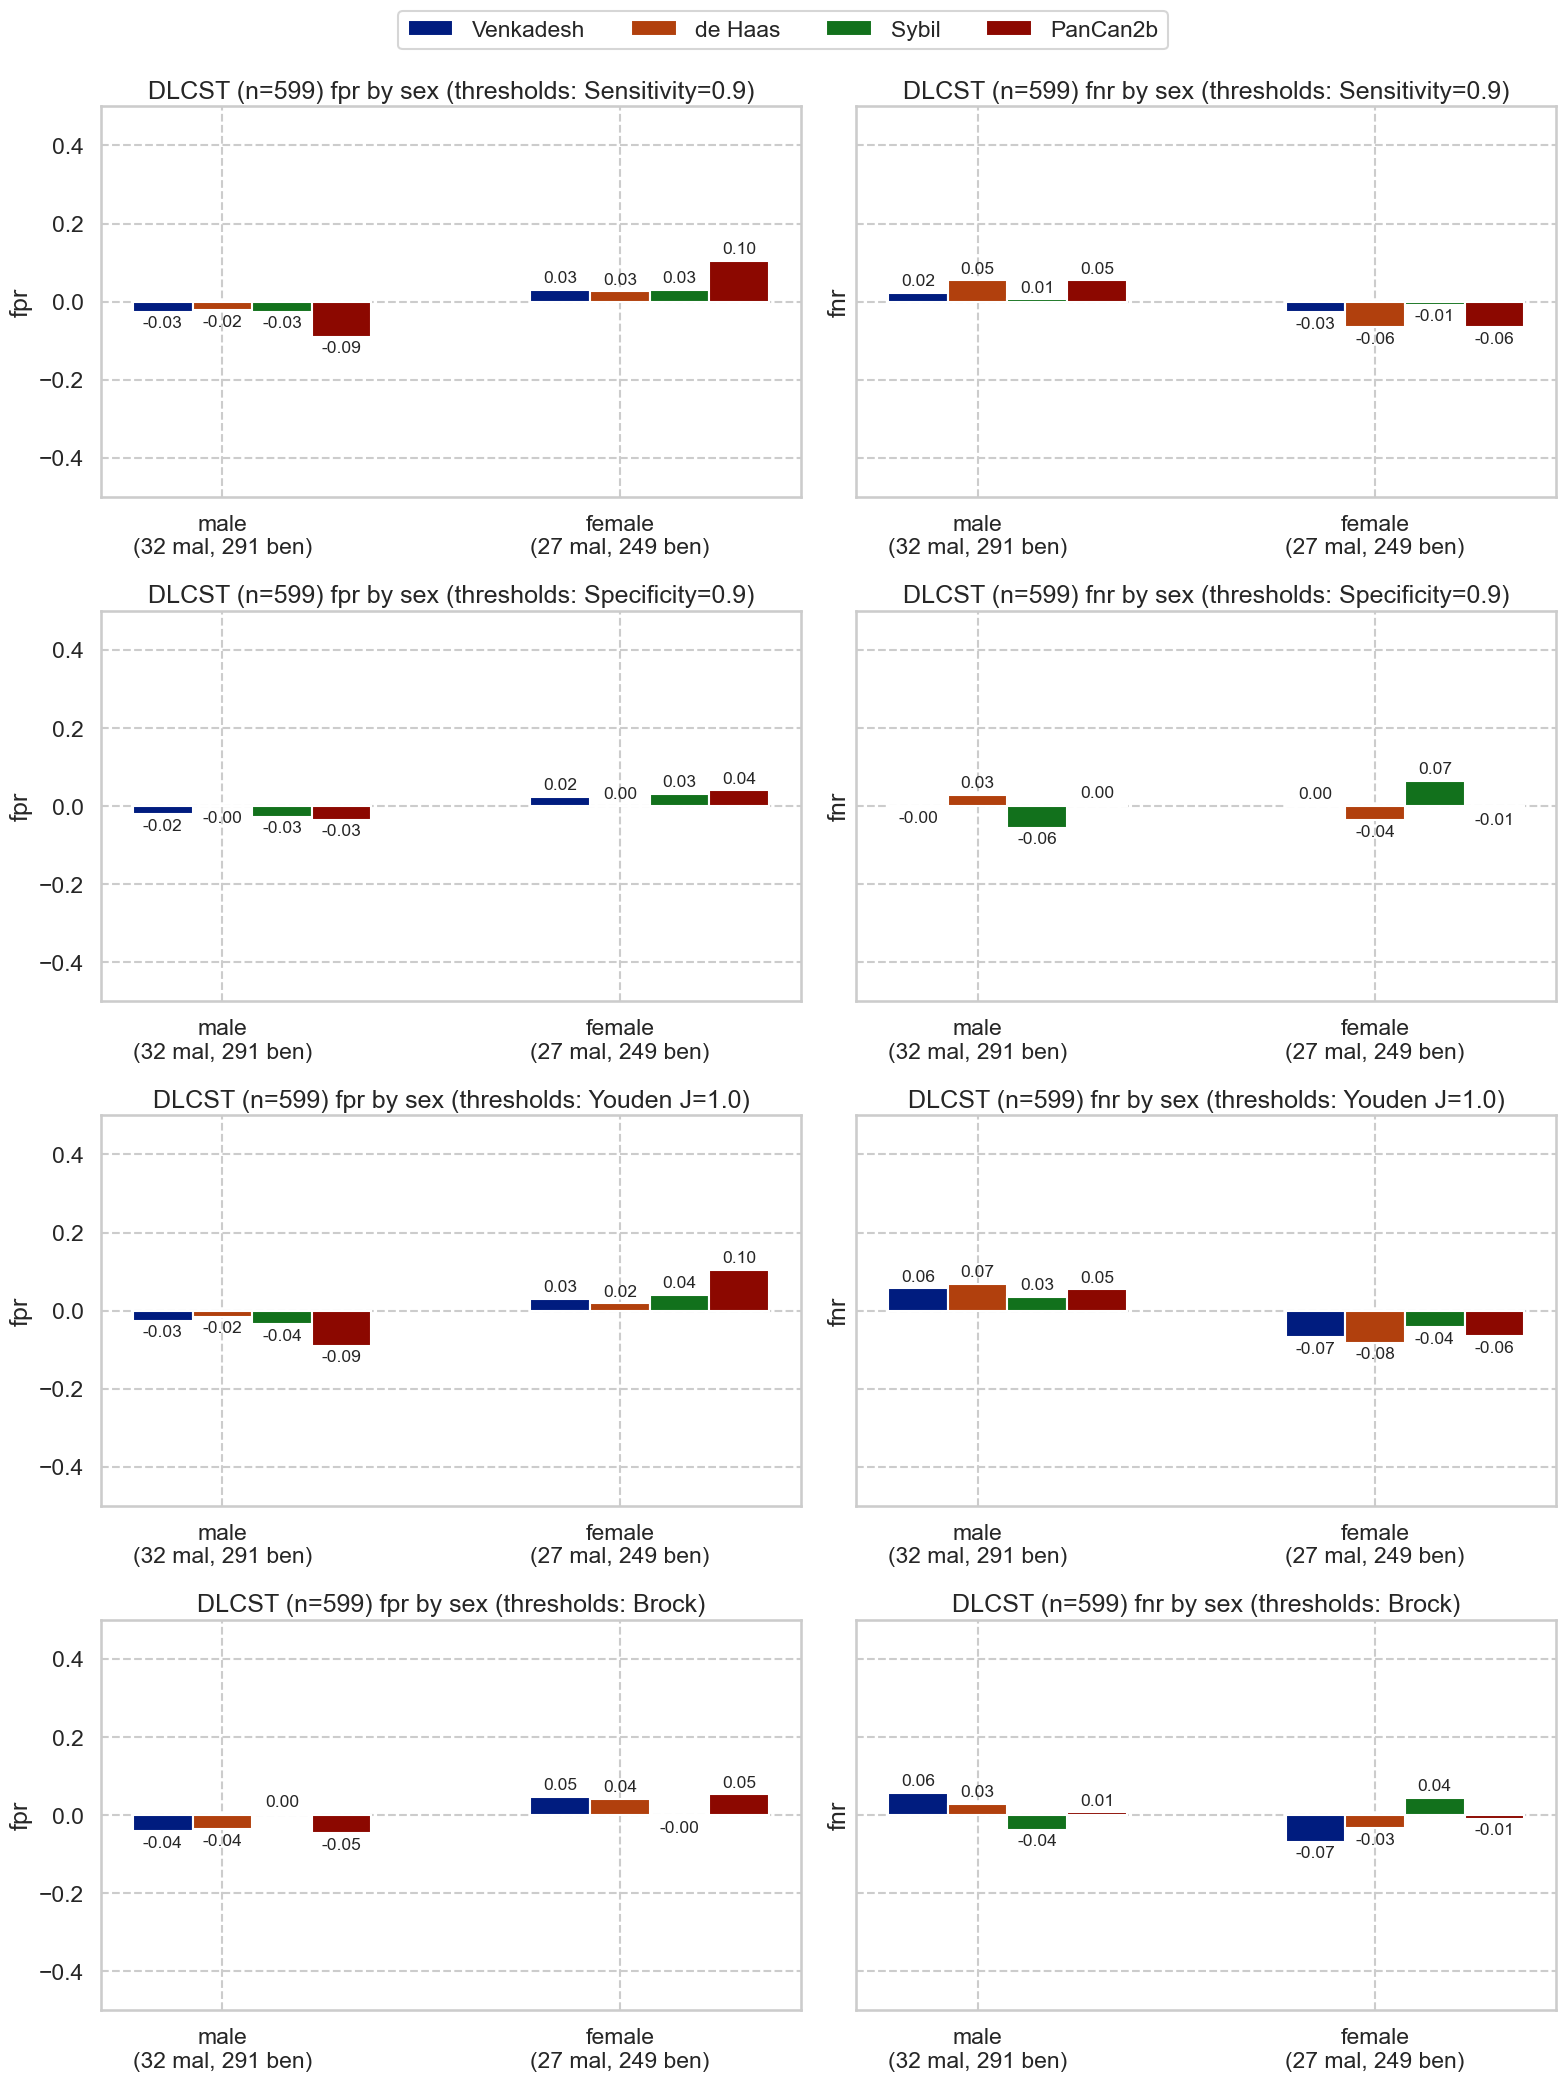

### family history

,num,pct,num_mal,pct_mal
no,497,82.971619,43,8.651911
yes,102,17.028381,16,15.686275


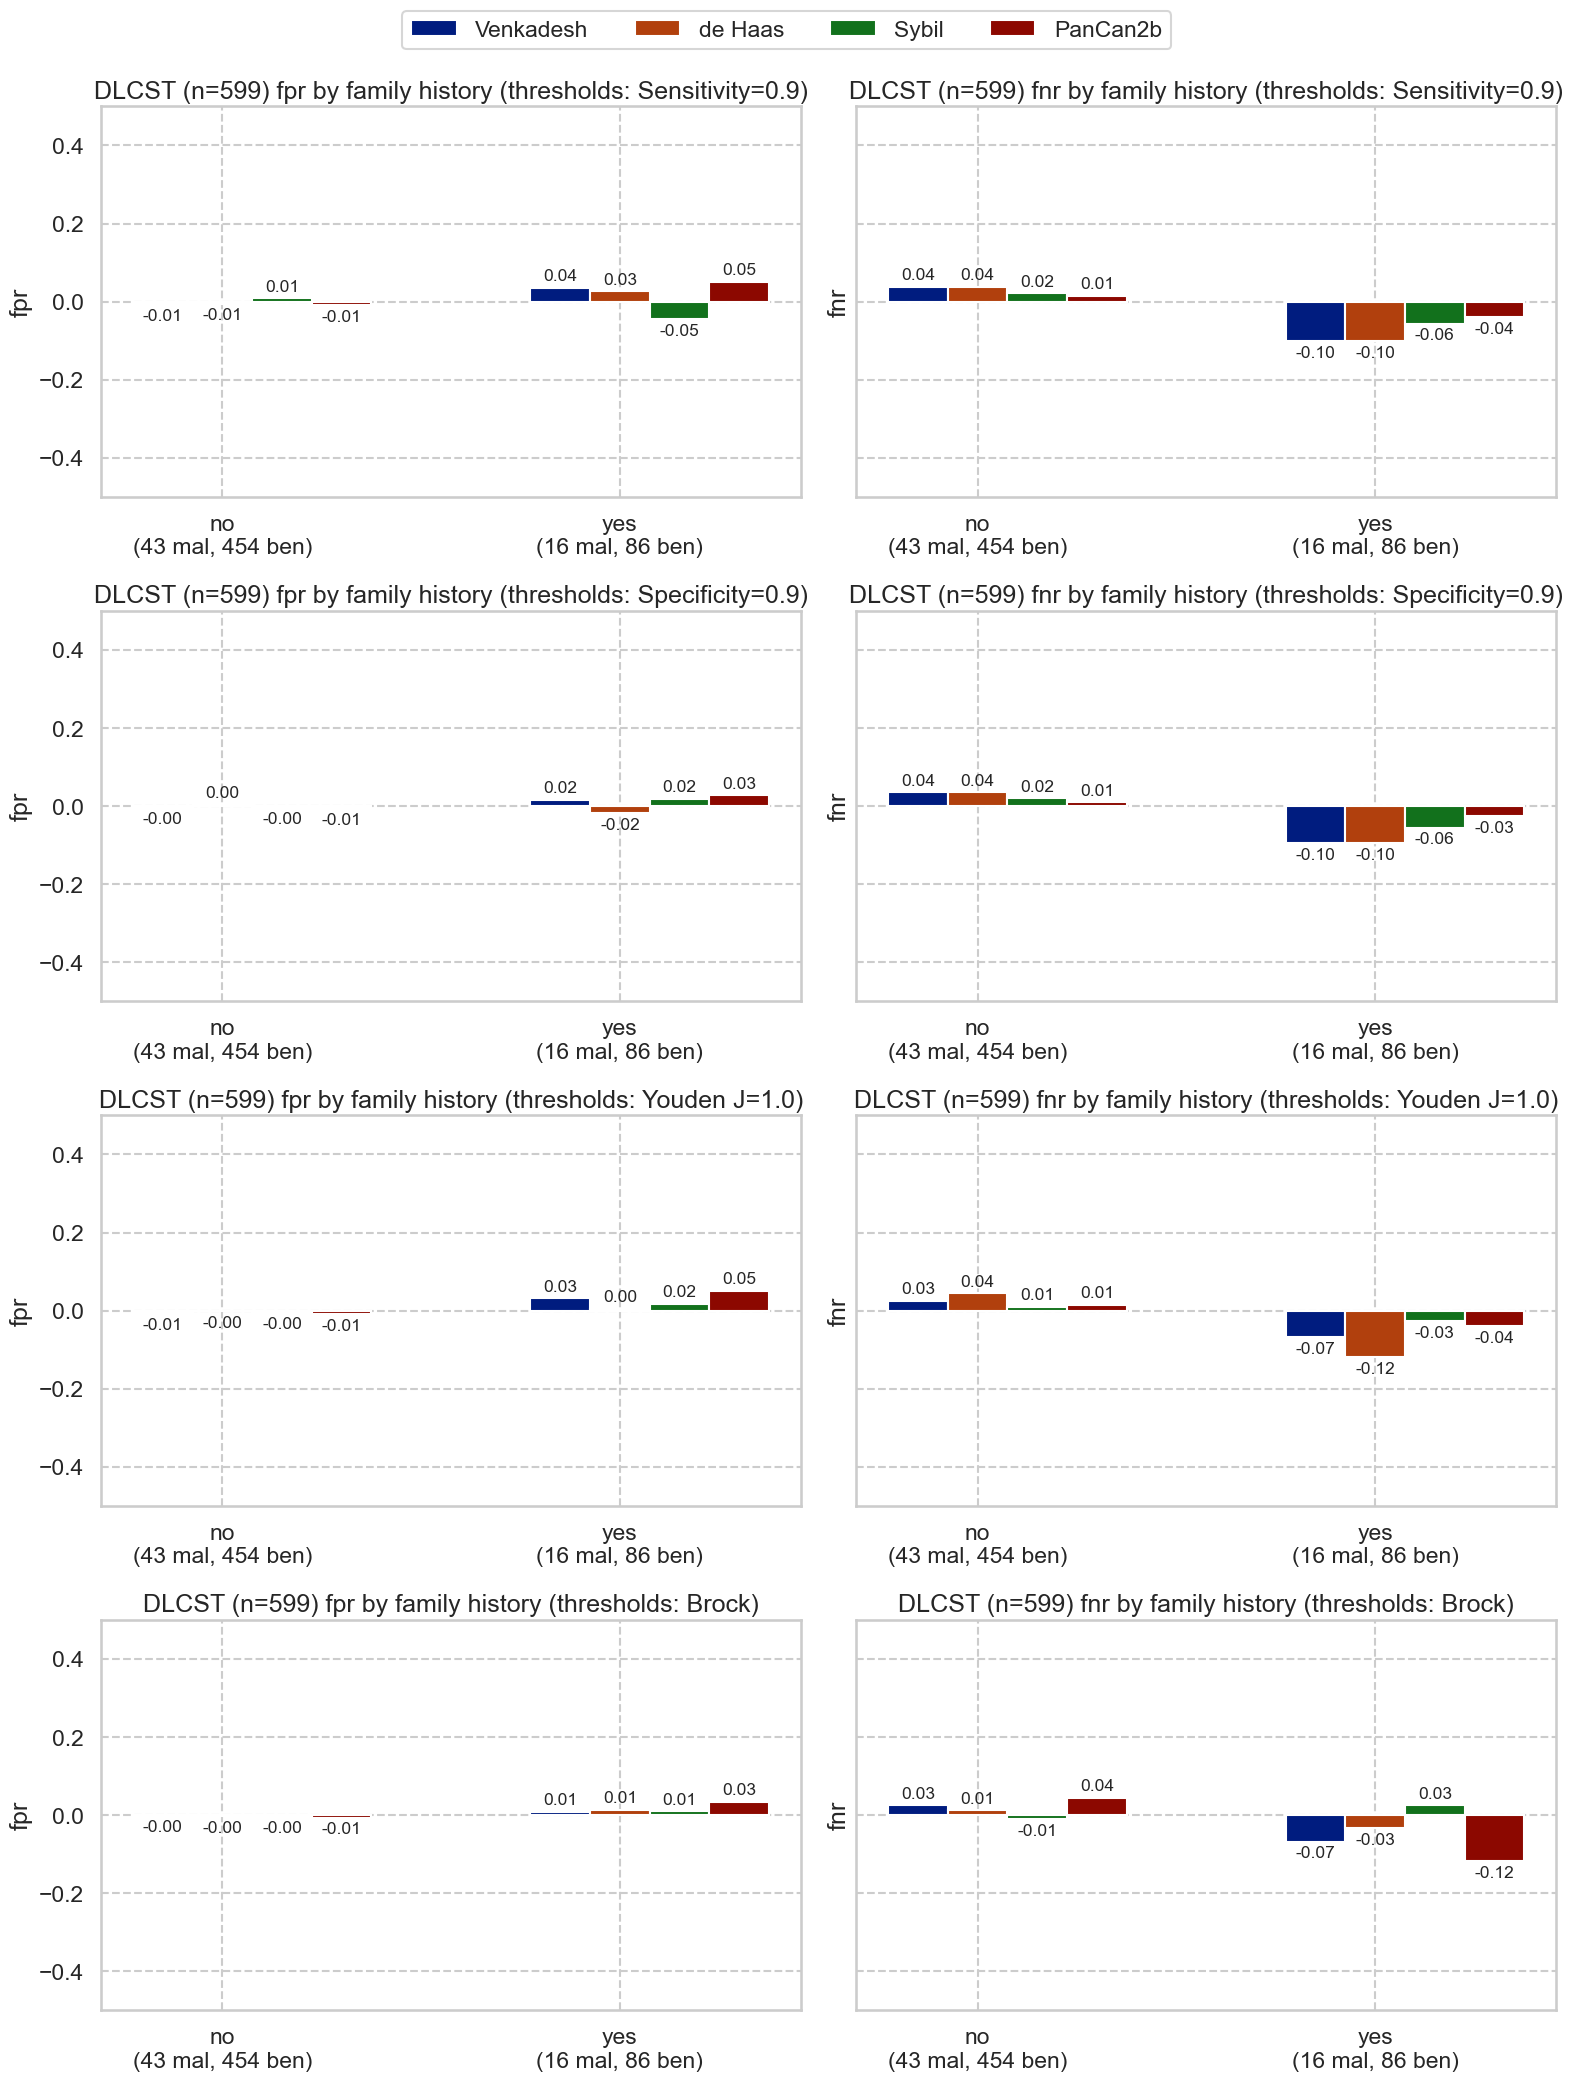

### emphysema

,num,pct,num_mal,pct_mal
no,194,32.387312,15,7.731959
yes,405,67.612688,44,10.864198


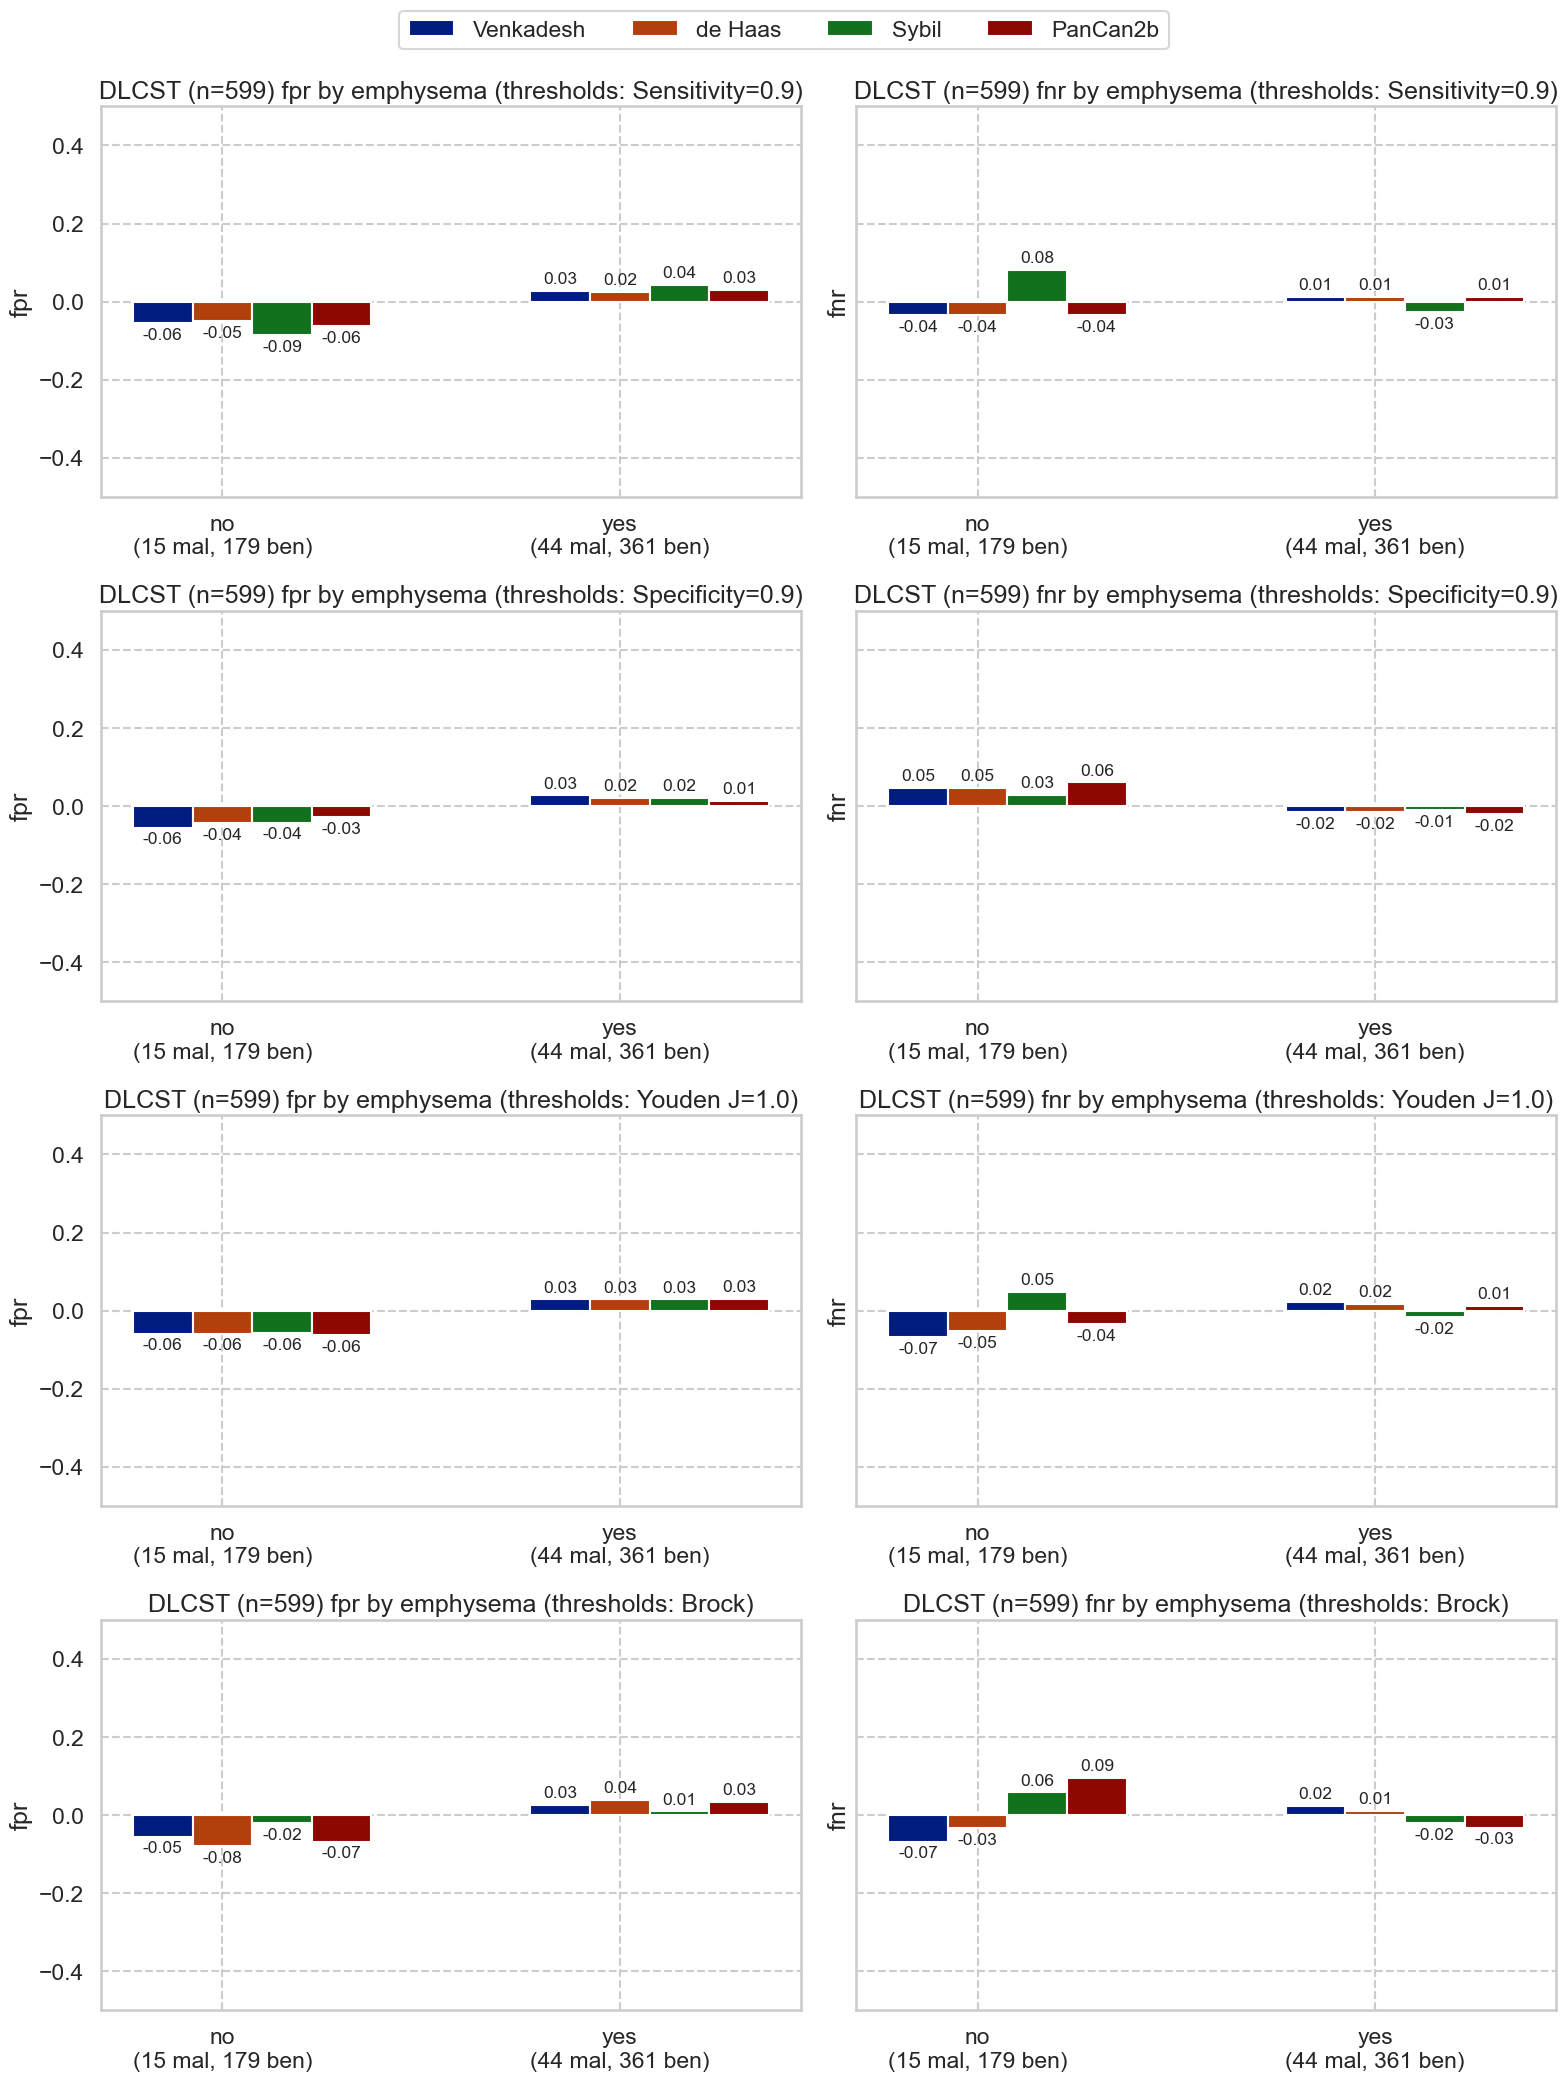

### age

,num,pct,num_mal,pct_mal
50-62,435,72.621035,28,6.436782
62+,164,27.378965,31,18.902439


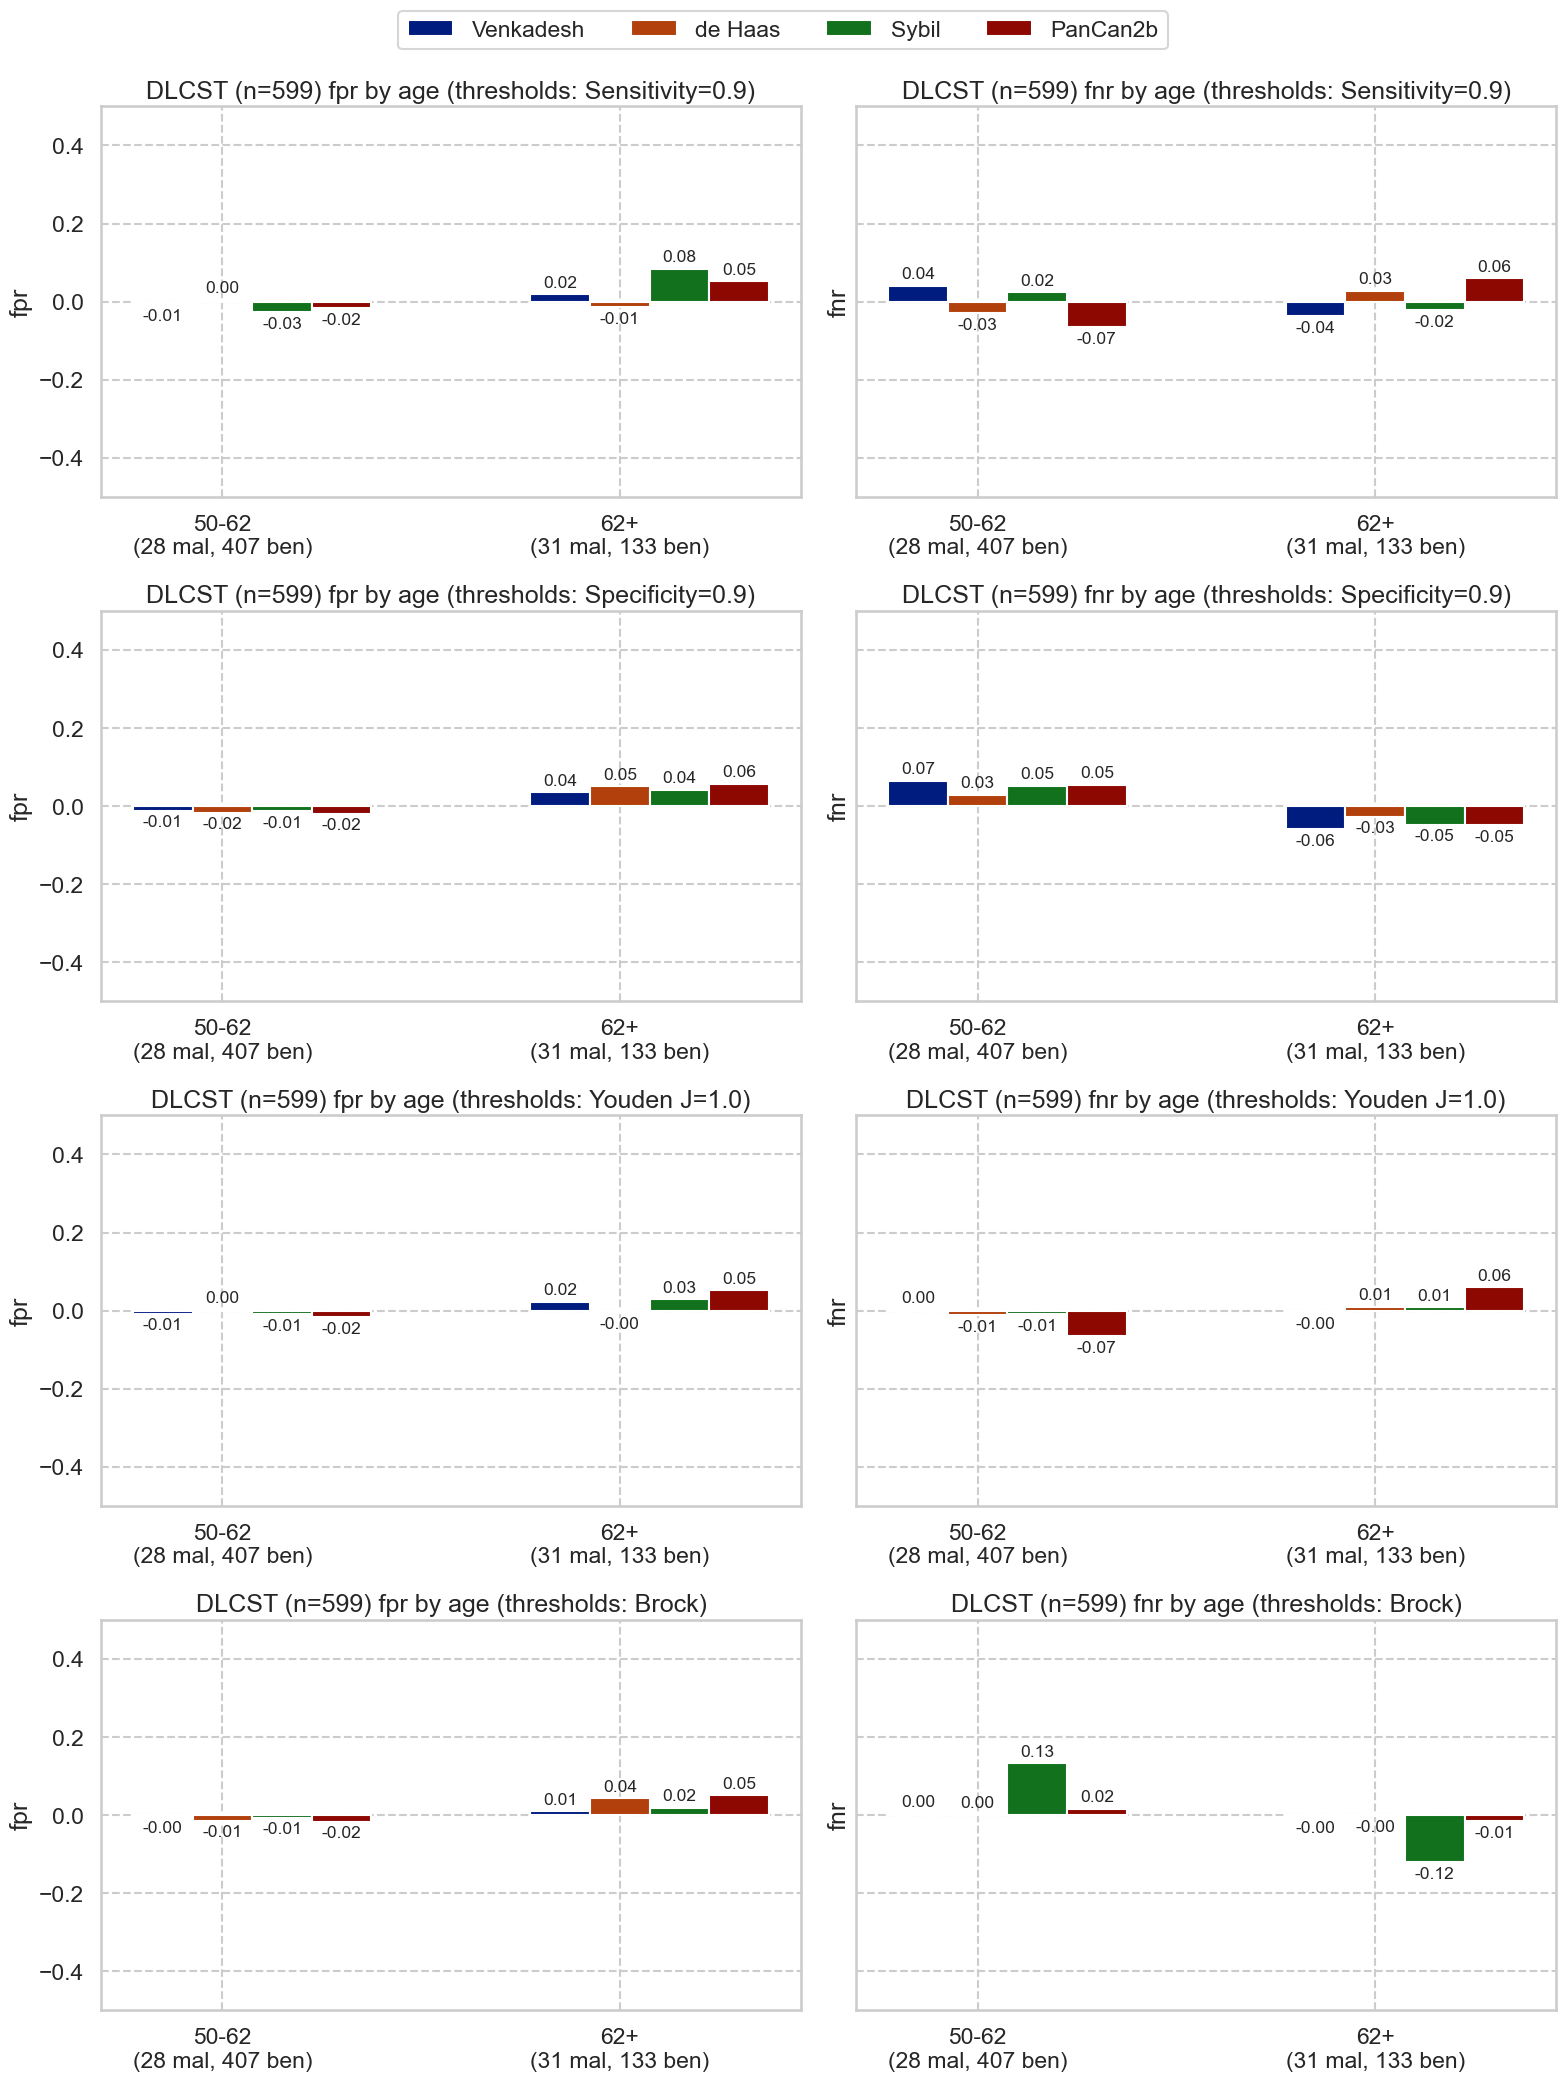

### nodule count

,num,pct,num_mal,pct_mal
1,333,55.592654,35,10.510511
>1,266,44.407346,24,9.022556


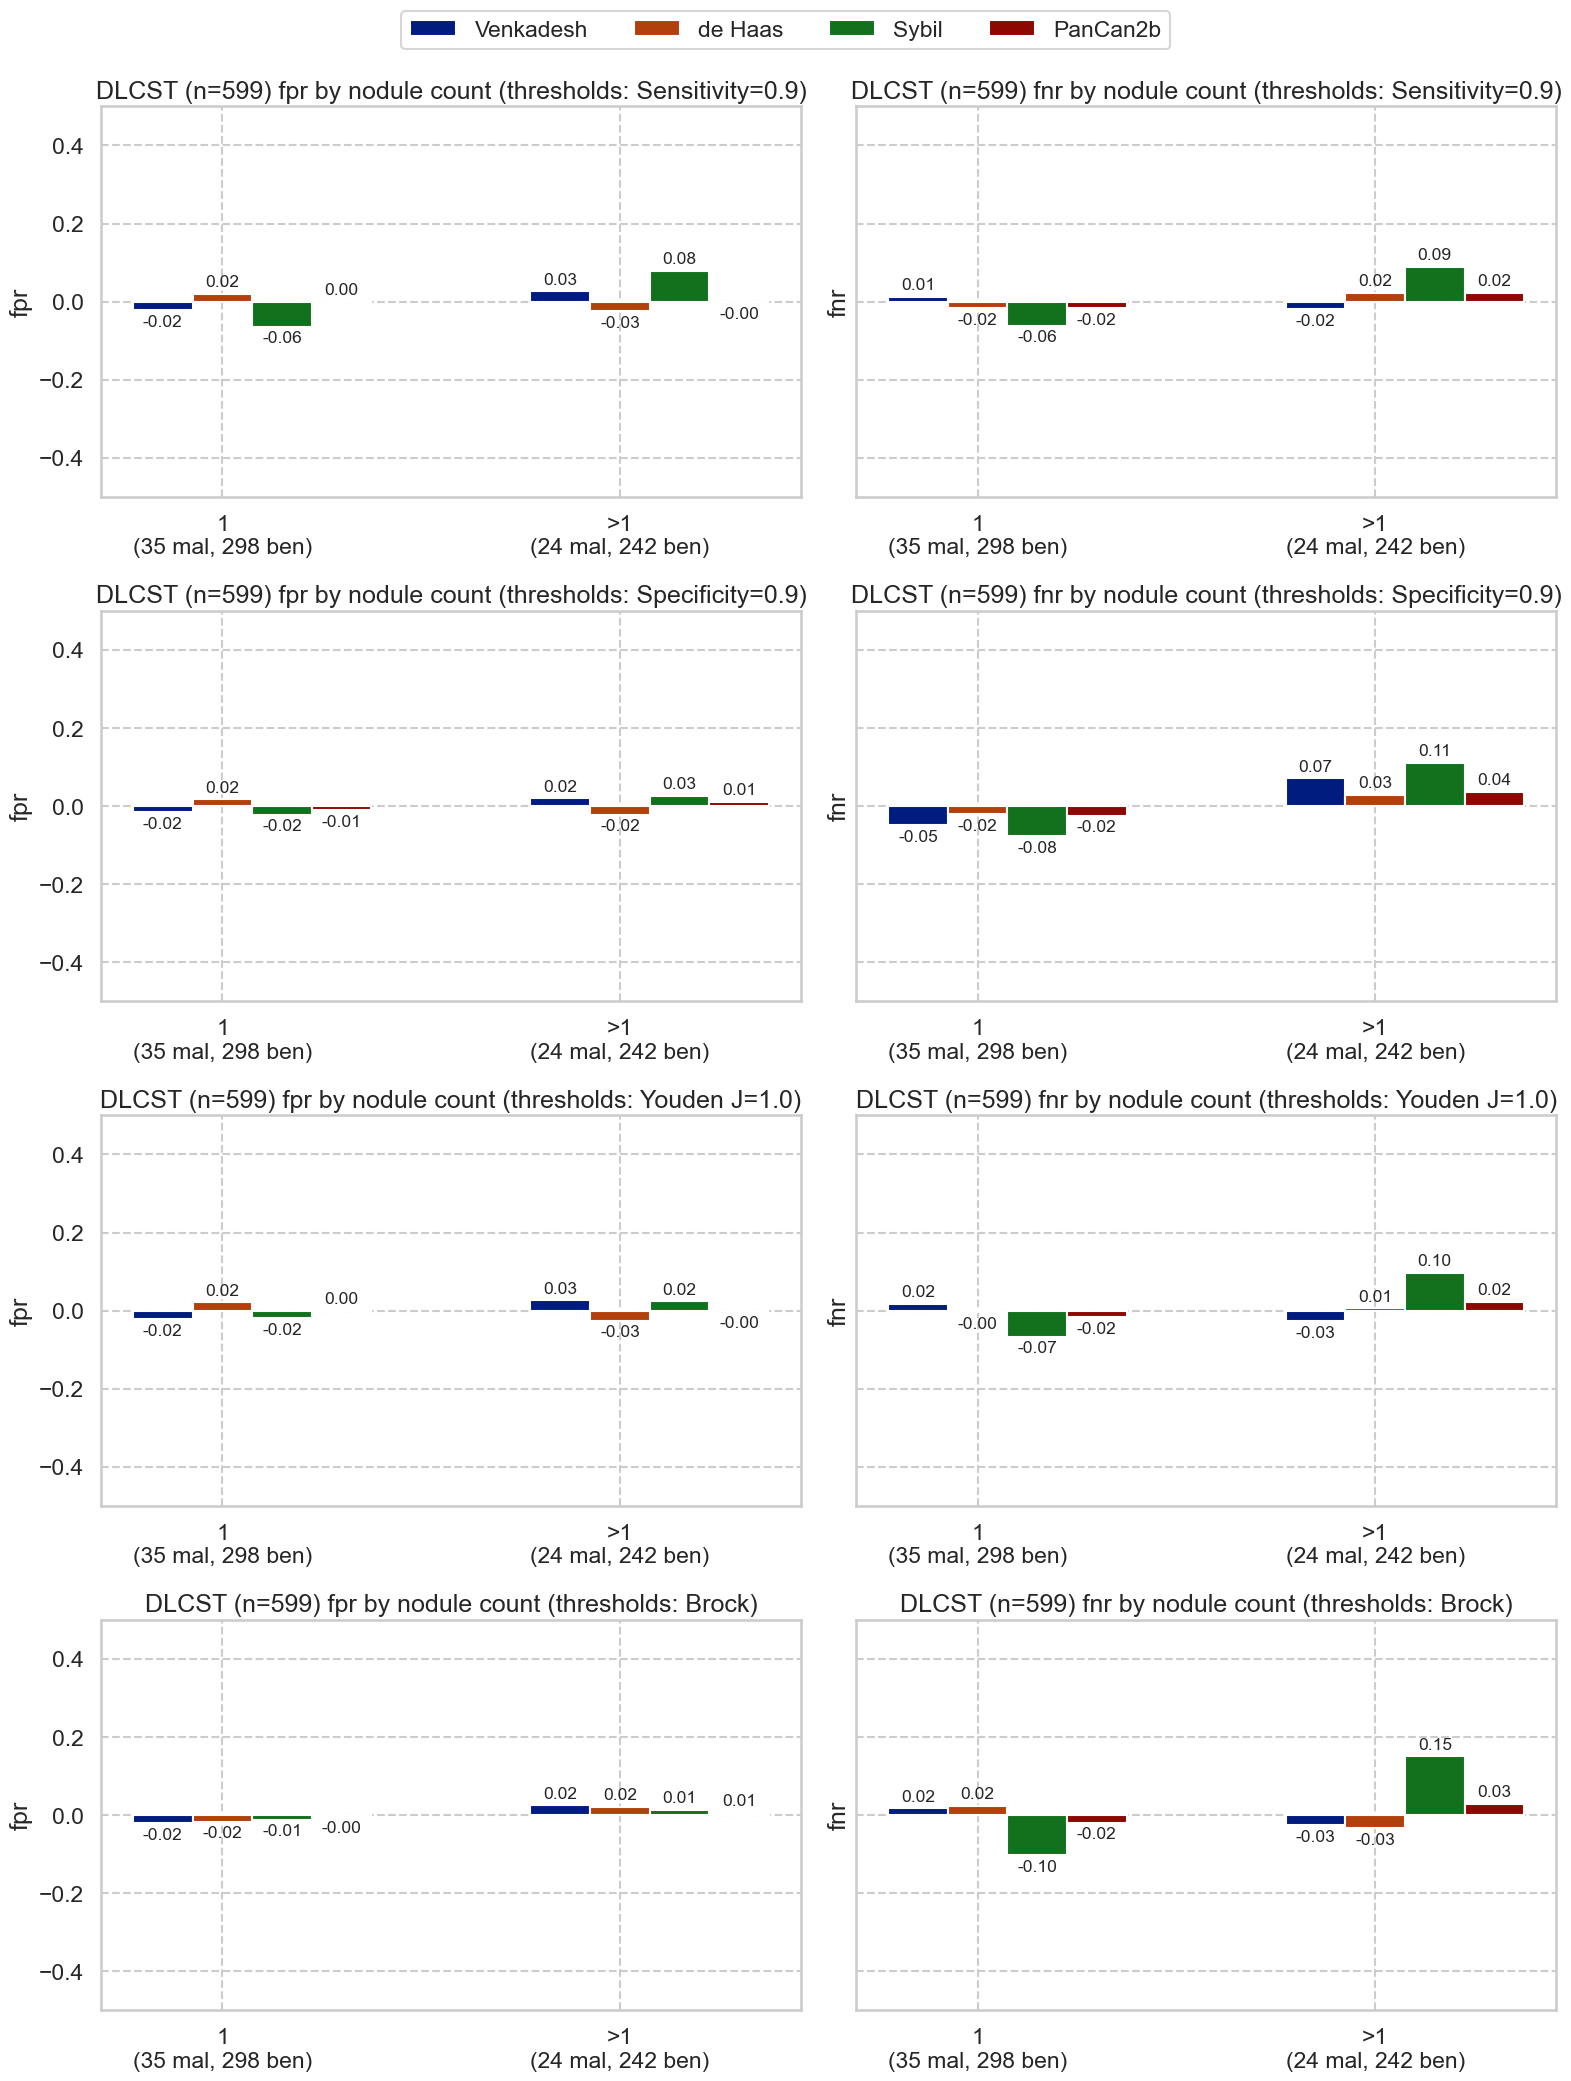

In [24]:
for q in SPLIT_QUERIES:
    plot_by_category(dlcst_preds, q)